# Set up environment

In [47]:
# Import necessary libraries
import statsmodels
import anndata as ad
import importlib
from multiprocessing import Pool
import os
import random
import sys
from collections import Counter
from functools import partial
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from scipy.stats import ttest_ind
from matplotlib.ticker import ScalarFormatter


from matplotlib.collections import PatchCollection
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.ticker import ScalarFormatter
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import numpy as np
import pandas as pd
import pickle5 as pkl
import scanpy as sc
import seaborn as sns
from scipy.stats import fisher_exact
from scipy.sparse import csr_matrix
from scipy.spatial import cKDTree
import skbio
import gseapy
import scipy
from statsmodels import stats
from sklearn.cluster import KMeans
from tqdm import tqdm
from alphashape import alphashape
from scipy.spatial import distance

# Additional imports related to plotting
from scipy.spatial import cKDTree
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import copy
from collections import Counter

# Additional scanpy and tqdm imports
import scanpy as sc
from tqdm import tqdm

# Import custom functions and modules
from slide_tcr_functions import (
    PuckReplicate,
    save_puck,
    load_puck,
    make_puck,
    make_adata,
    load_adata,
    pkl_load,
    pkl_dump,
    download_data,
)
from tcr_mapping import tcr_mapping, get_barcode_position, build_6mer_dist, barcode_matching
from plotting_functions import gaussian_heat_plot, plot_cortex_medulla
from perm_test_functions import perm_test_to_final_plot

# Set directory paths
directory = './scratch/publication/'  # Directory with all data
directory_slideseq = './scratch/publication'  # Slide-seq directory

# Set plotting parameters
fontprops = fm.FontProperties(size=18)
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams['ps.fonttype'] = 42

pixels_needed = 500 / 0.65

# Reload modules for development purposes
def reload_module(module):
    importlib.reload(module)

# Reload plotting module
reload_module(importlib.import_module('perm_test_functions'))
reload_module(importlib.import_module('slide_tcr_functions'))

# Reload permutation testing module if needed
# reload_module(importlib.import_module('perm_test_functions'))

# Other settings or configurations can be added here

In [6]:
# Load sample information from Google Sheets
spreadsheet_key = '1wvjq3GM6RGg-uZY8_LhNsjET-XOsPoQ1yH3cnhVWAdk'
xls = pd.ExcelFile(f"https://docs.google.com/spreadsheets/d/{spreadsheet_key}/export?format=xlsx")
master_df = pd.read_excel(xls, 'Slide-TCR-seq', header=1)

# Filter out rows with missing puck names
puck_name_col = 'NovaSeq alignment directory'
master_filt = master_df[~master_df[puck_name_col].isnull()]

# Initialize dictionaries and lists
csv_name_to_puck_name = {}
puck_name_to_timepoint = {}
age_to_ss = {}
puck_to_time = {}
csv_names = []

# Process rows in the master dataframe
for index, row in master_df.iterrows():
    puck_name = row[puck_name_col]
    age = row['Sample Age']
    sample_type = row['Lobe']

    # Skip human samples and non-Mouse_aging analysis types
    if sample_type == 'Human' or row['Analysis Type'] != 'Mouse_aging':
        continue

    # Skip rows with specified Barcodes to TCR csv values
    if row['Barcodes to TCR csv '] in ['in puck folder', 'merge_complete']:
        csv_name = f'{puck_name[11:25]}_B.csv'

        # Populate dictionaries and lists
        csv_name_to_puck_name[csv_name] = puck_name
        csv_names.append(csv_name)
        puck_name_to_timepoint[puck_name] = age

        if age not in age_to_ss:
            age_to_ss[age] = []
        age_to_ss[age].append(row[puck_name_col])
        puck_to_time[puck_name] = age

# Define mappings and orderings
time_to_puck = {puck_to_time[i]: i for i in puck_to_time}
tpt_to_pn = dict(zip(master_df['Sample Age'], master_df['NovaSeq alignment directory']))
tpt_order = ['0 day', '1 day', '2 day', '3 day', '4 day', '5 day', '7 day', '10 day', '13 day', '3wks', '4 wks', '5 wks', '7wks', '9 wks', '13 wks', '15wks', '28wks', '32wks', '48 wks', '68 wks', '90wks']

# Define timepoints, day mappings, and puck names
timepoints = tpt_order

# Load sample information
spreadsheet_key = '1wvjq3GM6RGg-uZY8_LhNsjET-XOsPoQ1yH3cnhVWAdk'
xls = pd.ExcelFile(
    f"https://docs.google.com/spreadsheets/d/{spreadsheet_key}/export?format=xlsx"
)
master_df = pd.read_excel(xls, 'Slide-TCR-seq', header=1)

puck_name_col = 'NovaSeq alignment directory'
master_filt = master_df[~master_df[puck_name_col].isnull()]

csv_name_to_puck_name = {}
puck_name_to_timepoint = {}
age_to_ss = {}
puck_to_time = {}
csv_names = []

for index,row in master_df.iterrows():
    puck_name = row['NovaSeq alignment directory']
    age = row['Sample Age']
    sample_type = row['Lobe']
    
    if sample_type == 'Human':
        continue
    if row['Analysis Type'] != 'Mouse_aging':
        continue
    if row['Barcodes to TCR csv '] in ['in puck folder','merge_complete']: #
        csv_name = f'{puck_name[11:25]}_B.csv'

        csv_name_to_puck_name[csv_name] = puck_name
        csv_names.append(csv_name)
        puck_name_to_timepoint[puck_name] = age
        
        if age not in age_to_ss:
            age_to_ss[age] = []
        age_to_ss[age].append(row[puck_name_col])
        puck_to_time[puck_name] = age

time_to_puck = {puck_to_time[i]: i for i in puck_to_time}

tpt_to_pn = {
    i: j
    for i, j in zip(master_df['Sample Age'],
                    master_df['NovaSeq alignment directory'])
}
tpt_order = [
    '0 day', '1 day', '2 day', '3 day', '4 day', '5 day', '7 day', '10 day',
    '13 day', '3wks', '4 wks', '5 wks', '7wks', '9 wks', '13 wks', '15wks',
    '28wks', '32wks', '48 wks', '68 wks', '90wks'
]


timepoints = [
    '1 day', '2 day', '3 day', '4 day', '5 day', '7 day', '10 day', '13 day',
    '3wks', '4 wks', '5 wks', '7wks', '9 wks', '13 wks', '15wks', '28wks',
    '32wks', '48 wks', '68 wks', '90wks'
]
tpt_to_day = {
    '0 day': 0,
    '1 day': 1,
    '2 day': 2,
    '3 day': 3,
    '4 day': 4,
    '5 day': 5,
    '7 day': 7,
    '10 day': 10,
    '13 day': 13,
    '3wks': 3 * 7,
    '4 wks': 4 * 7,
    '5 wks': 5 * 7,
    '7wks': 7 * 7,
    '9 wks': 9 * 7,
    '13 wks': 13 * 7,
    '15wks': 15 * 7,
    '28wks': 28 * 7,
    '32wks': 32 * 7,
    '48 wks': 48 * 7,
    '68 wks': 68 * 7,
    '90wks': 90 * 7
}

puck_names = ["2023-01-24_Puck_221024_23", # 0 day
                      "2022-11-23_Puck_221024_24", # 0 day
                "2022-11-23_Puck_221024_31", # 1 day
                      "2023-01-16_Puck_221024_27", # 1 day
                      "2022-11-23_Puck_221024_34", # 2 day
                      "2023-01-24_Puck_221024_33", # 2 day
                      "2023-01-24_Puck_221024_36", # 2 day
                      "2022-11-23_Puck_221024_38", # 3 day
                      "2023-01-24_Puck_221024_37", # 3 day
                      "2023-01-24_Puck_221024_39", # 3 day
                      "2023-01-24_Puck_221103_09", # 4 day
                      "2023-01-24_Puck_221103_12", # 4 day
                      "2023-01-24_Puck_221019_08", # 5 day
                      "2023-01-24_Puck_221019_05", # 5 day
                      "2023-01-24_Puck_221019_10", # 7 day
                      "2023-01-24_Puck_221019_14", # 7 day
                      "2022-12-16_Puck_221006_22_trunc", # 10 day
                      "2023-01-24_Puck_221006_23", # 10 day
                      "2022-12-16_Puck_221011_32_trunc", # 13 day
                      "2022-12-16_Puck_221011_33_trunc", # 13 day
                      "2023-01-24_Puck_221118_38", # 3 weeks
                      "2023-01-24_Puck_221118_39", # 3 weeks
                      "2023-01-24_Puck_221103_22", # 4 weeks
                      "2023-01-24_Puck_221118_40", # 4 weeks
                      "2023-01-24_Puck_220930_18", # 5 weeks
                      "2023-01-24_Puck_220930_20", # 5 weeks
                      "2023-01-24_Puck_220930_22", # 5 weeks
                      "2023-01-24_Puck_220930_23", # 7 weeks
                      "2023-01-24_Puck_220930_28", # 7 weeks
                      "2023-01-24_Puck_221011_37", # 9 weeks
                      "2023-01-24_Puck_221011_39", # 9 weeks
                      "2023-01-24_Puck_221011_12", # 13 weeks
                      "2023-01-24_Puck_221011_13", # 13 weeks
                      "2022-11-04_Puck_221006_24", # 15 week
                      "2022-12-16_Puck_221006_26_trunc", # 15 week
                      "2022-11-04_Puck_221006_29", # 28 week
                      "2022-12-16_Puck_221006_35_trunc", # 28 week
                      "2022-11-04_Puck_220930_32", # 32 week
                      "2022-12-16_Puck_220930_29_trunc", # 32 week
                      "2023-01-24_Puck_220930_35", # 32 week
                      "2023-01-24_Puck_221014_37", # 48 week
                      "2023-01-24_Puck_221019_03", # 48 week
                      "2022-12-16_Puck_221011_19_trunc", # 68 week
                      "2022-12-16_Puck_221011_20_trunc", # 68 week
                      "2023-01-24_Puck_221006_32", # 68 week
                      "2022-12-16_Puck_220930_37_trunc", # 90 week
                      "2022-12-16_Puck_220930_38_trunc"] # 90 week
puck_times = [0,0,1,1,2,2,2,3,3,3,4,4,5,5,7,7,10,10,13,13,3*7,3*7,4*7,4*7,5*7,5*7,5*7,
              7*7,7*7,9*7,9*7,13*7,13*7,15*7,15*7,28*7,28*7,32*7,32*7,32*7,48*7,48*7,68*7,68*7,68*7,90*7,90*7]


puck_name_to_days = dict(zip(puck_names, puck_times))

# Define batch mappings
batch_to_tpt = dict(zip(range(len(puck_times)), puck_times))
batch_to_puck_name = dict(zip(range(len(puck_times)), puck_names))

In [7]:
def dilate_cortex_points(bc_cortex, bc_medulla, bc_loc_dict_s1,
                         loc_to_bc_s1, matched_bead_barcodes, locs_cortex, filt_plot=False):
    """
    Dilate cortex points based on the median diversity of nearby points.

    Parameters:
    - bc_cortex: List of cortex barcodes
    - bc_medulla: List of medulla barcodes
    - bc_loc_dict_s1: Dictionary mapping barcodes to locations
    - loc_to_bc_s1: Dictionary mapping locations to barcodes
    - matched_bead_barcodes: List of matched bead barcodes
    - locs_cortex: List of cortex locations
    - filt_plot: Boolean flag to filter the plot

    Returns:
    - Dictionary mapping cortex locations to diluted diversity values
    """

    # Extract cortex locations
    cortex_locs = [bc_loc_dict_s1[bc] for bc in bc_cortex]

    # Extract all locations (cortex + medulla)
    everywhere_locs = [bc_loc_dict_s1[bc] for bc in bc_medulla + bc_cortex]

    # If there are fewer than 2 cortex locations, skip dilation
    if len(cortex_locs) < 2:
        return 'Skip'

    point_tree = cKDTree(cortex_locs)

    # Create a copy of loc_to_diversity for cortex locations
    cort_loc_to_diversity = copy.deepcopy(loc_to_diversity)

    # Iterative dilation process
    num_iter = 0
    while num_iter != 2:  # Limiting the number of iterations for demonstration (can be adjusted)
        num_iter += 1
        print(f"Iteration: {num_iter}")
        print(f"Number of Cortex Locations: {len(cort_loc_to_diversity)}")

        # Find unassigned cortex locations
        unassigned_cortex_locs = [loc for loc in cortex_locs if loc not in cort_loc_to_diversity]

        # Dilate unassigned cortex locations
        for loc in unassigned_cortex_locs:
            # Find points within a radius of 20 units
            idx_closeby_points = point_tree.query_ball_point(loc, r=20 / 0.65)
            nearest_points = [cortex_locs[idx] for idx in idx_closeby_points]

            # Extract diversity values for nearby points
            div = [cort_loc_to_diversity[i] for i in nearest_points if i in cort_loc_to_diversity]

            # If there are diversity values, assign the median to the current location
            if len(div) > 0:
                cort_loc_to_diversity[loc] = np.median(div)

        # Make a plot
        plot_dilated_cortex(cort_loc_to_diversity, everywhere_locs, cortex_locs, locs_cortex, filt_plot)

    print('Hotspot dilation complete')
    return cort_loc_to_diversity


def plot_dilated_cortex(cort_loc_to_diversity, everywhere_locs, cortex_locs, locs_cortex, filt_plot):
    """
    Plot the dilated cortex.

    Parameters:
    - cort_loc_to_diversity: Dictionary mapping cortex locations to diluted diversity values
    - everywhere_locs: List of all locations (cortex + medulla)
    - cortex_locs: List of cortex locations
    - locs_cortex: List of cortex locations for filtering
    - filt_plot: Boolean flag to filter the plot
    """
    fig, ax = plt.subplots(figsize=(5, 5))

    # Plot everywhere locations in gray
    x2, y2 = zip(*everywhere_locs)
    plt.scatter(x2, y2, c='gray', s=1, alpha=0.05)  # Everywhere

    # Plot cortex locations in gray with higher alpha
    x2, y2 = zip(*cortex_locs)
    plt.scatter(x2, y2, c='gray', s=1, alpha=0.2)

    # Plot diluted cortex locations
    if filt_plot:
        locs_filt, c = zip(*[(loc, c) for loc, c in zip(list(cort_loc_to_diversity.keys()), list(cort_loc_to_diversity.values())) if loc in locs_cortex])
        x, y = zip(*locs_filt)
    else:
        x, y = zip(*list(cort_loc_to_diversity.keys()))
        c = list(cort_loc_to_diversity.values())

    # Scatter plot with color map
    p = plt.scatter(x, y, c=c, s=1, cmap='inferno', vmin=3.3, vmax=5.4)

    # Additional plot settings
    plt.axis('off')
    plt.xlim([0, 5000])
    plt.ylim([0, 5000])
    cb_ax = fig.add_axes([.91, .124, .04, .754])
    fig.colorbar(p, orientation='vertical', cax=cb_ax)
    fontprops = fm.FontProperties(size=18)
    scalebar = AnchoredSizeBar(
        ax.transData,
        pixels_needed,
        "",
        "lower right",
        pad=0.1,
        color="black",
        frameon=False,
        size_vertical=1,
        fontproperties=fontprops,
    )
    ax.add_artist(scalebar)

    plt.show()


# Example usage:
# dilate_cortex_points(bc_cortex, bc_medulla, bc_loc_dict_s1, loc_to_bc_s1, matched_bead_barcodes, locs_cortex, filt_plot=False)

def plot_gene_expression_on_pucks(pucks_to_plot, genes_to_plot):
    """
    Plot gene expression on specified pucks for selected genes.

    Parameters:
    - pucks_to_plot: List of puck names to be plotted
    - genes_to_plot: List of gene names to be plotted

    Returns:
    - None
    """
    vmax_calc = {i: [] for i in genes_to_plot}
    vmax_for_genes = {i: 0 for i in genes_to_plot}  # identify 90th percentile
    vmin_calc = {i: [] for i in genes_to_plot}
    vmin_for_genes = {i: 0 for i in genes_to_plot}  # identify 90th percentile
    all_x_agg = {}
    all_y_agg = {}
    all_adata_filt = {}
    all_total_counts = {}

    # Calculate vmax values
    for pn in tqdm(pucks_to_plot):
        if pn not in loaded_pucks:
            with open(f'{directory}{pn}_raw.h5ad', "rb") as handle:
                adata = sc.read_h5ad(handle)
            loaded_pucks[pn] = adata
        else:
            adata = loaded_pucks[pn]
        all_x = adata.obs['x']
        all_y = adata.obs['y']

        all_x_agg[pn] = all_x
        all_y_agg[pn] = all_y

        adata = adata[adata.obs['cortex_medulla'].isin(['cortex', 'medulla'])]  # clean up areas outside tissue
        all_adata_filt[pn] = adata

        total_counts_per_cell = np.sum(adata.X, axis=1)
        all_total_counts[pn] = total_counts_per_cell

        for gene_name in genes_to_plot:
            gene_idx = list(adata.var.index).index(gene_name)
            gene_filt = adata.X[:, gene_idx]
            gene_filt = [i / x * 10000 for i, x in zip(gene_filt, total_counts_per_cell)]

            bc_indices = [index for index, val in enumerate(gene_filt) if val > 0]
            gene_filt = [val for index, val in enumerate(gene_filt) if val > 0]

            vmax_calc[gene_name] = vmax_calc[gene_name] + gene_filt
            vmin_calc[gene_name] = vmin_calc[gene_name] + gene_filt

    # Set percentile for plotting visualization
    vmax_for_genes = {i: np.percentile(vmax_calc[i], 90) for i in vmax_calc}  # Make cutoff 90th percentile of max
    vmin_for_genes = {i: np.percentile(vmin_calc[i], 10) for i in vmin_calc}  # Make cutoff 90th percentile of max

    # Create plots
    plt.figure(figsize=(len(genes_to_plot) * 4, len(pucks_to_plot) * 4))
    plt.subplots_adjust(hspace=0.5)
    plt_cter = 1

    # Make plots
    for pn in tqdm(pucks_to_plot):
        all_x = all_x_agg[pn]
        all_y = all_y_agg[pn]

        adata = all_adata_filt[pn]  # clean up areas outside tissue
        total_counts_per_cell = all_total_counts[pn]

        for gene_name in genes_to_plot:
            ax = plt.subplot(len(pucks_to_plot), len(genes_to_plot), plt_cter)
            ax.scatter(all_x, all_y, c='black', s=1)  # Plot locations in black

            gene_idx = list(adata.var.index).index(gene_name)
            gene_filt = adata.X[:, gene_idx]
            gene_filt = [i / x * 10000 for i, x in zip(gene_filt, total_counts_per_cell)]
            all_len = len(gene_filt)

            bc_indices = [index for index, val in enumerate(gene_filt) if val > 0]
            gene_filt = [val for index, val in enumerate(gene_filt) if val > 0]
            x = [adata.obs['x'][i] for i in bc_indices]
            y = [adata.obs['y'][i] for i in bc_indices]

            vmax_calc[gene_name] = vmax_calc[gene_name] + gene_filt

            vmin = vmin_for_genes[gene_name]
            vmax = vmax_for_genes[gene_name]
            thisfig = ax.scatter(x, y, c=gene_filt, s=1, cmap='viridis', vmin=vmin, vmax=vmax)
            fig.colorbar(thisfig)
            ax.set_title(f"{gene_name} {len(gene_filt)/all_len:.2%}")

            plt_cter += 1
            ax.set_xlim([0, 5000])
            ax.set_ylim([0, 5000])
            ax.set_aspect('equal')

            scalebar = AnchoredSizeBar(
                ax.transData,
                pixels_needed,
                "",
                "lower right",
                pad=0.1,
                color="black",
                frameon=False,
                size_vertical=1,
                fontproperties=fontprops,
            )
            ax.add_artist(scalebar)

    plt.show()

# Example usage:
# plot_gene_expression_on_pucks(pucks_to_plot, genes_to_plot)


def rolling_average(x, y, title):
    # Create a scatter plot of the data points
    fig, ax = plt.subplots() 
    plt.scatter(x, y)
    
    # Calculate the slope (m) and intercept (b) of the line
    m, b = np.polyfit(np.log10(x), y, 1)

    # Generate x values for the line of best fit
    x_fit = np.linspace(min(x), max(x), 10)

    # Calculate corresponding y values using the equation of the line
    y_fit = m * np.log10(x_fit) + b
    
    # Plot the line of best fit
    plt.plot(x_fit, y_fit, color='red', label=f'Line of Best Fit: y = {m:.2f}x + {b:.2f}')

    # Calculate and display Pearson correlation coefficient and p-value
    stat, pval = scipy.stats.pearsonr(np.log10(timepoints), y)
    plt.title(f'R = {round(stat,2)} | p = {round(pval,5)}')
    
    # Set x-axis scale to logarithmic
    ax.set_xscale('log', base=10)
    ax.set_xticks([20, 100, 500])
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    
    # Save the plot as a PDF file
    plt.savefig(f'{title}_sc_proportion.pdf')

def find_nearest_point_distance(target_point, list_of_points):
    """
    Find the point in a list of points closest to a target point.

    Parameters:
    - target_point (tuple): The target point in the form of (x, y).
    - list_of_points (list of tuples): List of points in the form of [(x1, y1), (x2, y2), ...].

    Returns:
    - nearest_point (tuple): The point in the list closest to the target point.
    - distance_to_nearest (float): The distance between the target point and the nearest point.
    """
    target_point = np.array(target_point)
    
    # Calculate Euclidean distances between the target point and all points in the list
    distances = distance.cdist(target_point, list_of_points, metric='euclidean')
    
    # Find the index of the nearest point
    index_of_nearest = np.argmin(distances)

    # Get the nearest point and its distance to the target point
    nearest_point = list_of_points[index_of_nearest]
    distance_to_nearest = distances[0, index_of_nearest]

    return nearest_point, distance_to_nearest

def calculate_distance_to_boundary(cluster_points, points_of_interest, alpha=0.03, show_plot = False):
    """
    Calculate the distance from each point in a cluster to the boundary of the alpha shape.

    Parameters:
    - cluster_points (list of tuples): List of (x, y) coordinates for the points in the cluster.
    - alpha (float): Alpha parameter for alpha shape. Smaller alpha values will create more detailed shapes.

    Returns:
    - distances (list of floats): List of distances from each point to the boundary.
    - boundary (list of tuples): List of (x, y) coordinates representing the boundary of the alpha shape.
    """

    # Convert the list of tuples to a numpy array for compatibility with alphashape
    points = np.array(cluster_points)
    x,y = zip(*points)
    # Create the alpha shape
    alpha_shape = alphashape(points, alpha=alpha)

    shape_x, shape_y = alpha_shape.exterior.coords.xy
    
    boundary = list(zip(shape_x,shape_y))
    if show_plot:
        plt.figure(figsize=(3,3))
        plt.plot(x, y, 'o', color='black', markersize=6)
        plt.plot(shape_x, shape_y, 'o', color='red', markersize=4)
        plt.xlim([0,5000])
        plt.ylim([0,5000])
        plt.show()
    
    # Calculate the distance from each point to the boundary
    distances = [find_nearest_point_distance([point], boundary) for point in points_of_interest]

    return alpha_shape, distances, boundary



In [14]:
# For each point, find nearest neighbors and build a nearest neighbors matrix

def make_neighbors_matrix(adata_to_use,  neighbors_list = False, num_cells = 100, mac_state = False):
    if mac_state:
        x_char = 'x'
        y_char = 'y'
    else:
        x_char = 'x_val'
        y_char = 'y_val'

    neighbors_list = [i for i in neighbors_list if i != 'NA']
    neighbors_list = [i for i in neighbors_list if i != 'None']
    interaction_recorder = np.zeros((adata_to_use.shape[0],len(neighbors_list)))

    for b in tqdm(list(set(adata_to_use.obs.Batch))):
        adata_batch = adata_to_use[adata_to_use.obs.Batch == b]
        locs = list(zip(adata_batch.obs[x_char], adata_batch.obs[y_char]))
        loc_to_cell_type = dict(zip(locs, adata_batch.obs.Cell_type))
        tree = cKDTree(locs)

        loc_idx = 0
        for l in locs:

            _, result_indices = tree.query(l, num_cells)
            points_within_distance = [locs[i] for i in result_indices]
            cells_within_distance = Counter([loc_to_cell_type[i] for i in points_within_distance])
            for ct in cells_within_distance:
                if ct == 'NA':
                    continue
                if ct == 'None':
                    continue
                id2 = neighbors_list.index(ct)
                interaction_recorder[loc_idx, id2] = cells_within_distance[ct]
            loc_idx += 1
    
    interaction_recorder_norm = interaction_recorder / np.sum(interaction_recorder, axis=1, keepdims=True)
    return interaction_recorder_norm

def drop_na_rows(numpy_array):

    # Select rows without NaN values
    numpy_array[np.isnan(numpy_array)] = 0
    
    return numpy_array

# Start analysis

In [9]:
# Read the AnnData file
adata = sc.read_h5ad('/data/liulab/sophia/thymuscombined_raw_cortex_medulla.h5ad')

# Directory where embeddings are stored
direc = '/data/liulab/sophia/embeddings'

# Define timepoints corresponding to puck names
puck_times = [0,0,1,1,2,2,2,3,3,3,4,4,5,5,7,7,10,10,13,13,3*7,3*7,4*7,4*7,5*7,5*7,5*7,
              7*7,7*7,9*7,9*7,13*7,13*7,15*7,15*7,28*7,28*7,32*7,32*7,32*7,48*7,48*7,68*7,68*7,68*7,90*7,90*7]

# Map puck names to days
puck_name_to_days = dict(zip(puck_names, puck_times))

# Define batch mappings
batch_to_tpt = dict(zip(range(len(puck_times)), puck_times))

# Get ages based on batch information
ages = [batch_to_tpt[i] for i in adata.obs.Batch]

# Load the embeddings
test = pd.read_csv(f'{direc}/thymus.csv')
test.drop(columns='Unnamed: 0', inplace=True)

# Access relevant information
X_gene_expression = test  # Gene expression data
age = np.log10(ages)  # Age information
batch = adata.obs.Batch  # Batch information

# Read another AnnData object
adata_rctd_inc = sc.read_h5ad(f'{directory}/Thymus_data_TCR_locs_diver.h5ad')

# Create a dictionary mapping barcode to cell type
bc_to_ct = {i: j for i, j in zip(adata_rctd_inc.obs.index, adata_rctd_inc.obs.Cell_type)}

# Annotate cell types for each barcode in adata
ct_annot = []
for bc in adata.obs.index:
    if bc in bc_to_ct:
        ct_annot.append(bc_to_ct[bc])
    else:
        ct_annot.append('NA')

# Add cell type annotation to adata
adata.obs['Cell_type'] = ct_annot


/tmp/ipykernel_26037/399305522.py:30: RuntimeWarning: divide by zero encountered in log10
  age = np.log10(ages)  # Age information


In [11]:
# Assign adata to adata_use
adata_use = adata

# Extract unique cell types from adata_use
neighbors_list = list(set(adata_use.obs.Cell_type))

# Generate interaction recorder matrix based on cell types
interaction_recorder_norm = make_neighbors_matrix(adata_use, neighbors_list, mac_state=True)

# Store the interaction recorder matrix as neighbor vectors in adata_use
adata_use.obsm['neighbor_vectors'] = interaction_recorder_norm

# Assign age information to the 'Age' column in adata_use's observations
adata_use.obs['Age'] = [batch_to_tpt[i] for i in adata_use.obs.Batch]

# Combine 'Age' and 'Batch' into a DataFrame for metadata
metadata = pd.DataFrame({'Batch': batch, 'Age': age})

# Create a new AnnData object from the test data
adata_adj = ad.AnnData(test)

# Transfer observations from adata_use to adata_adj
adata_adj.obs = adata_use.obs


100%|██████████| 47/47 [03:23<00:00,  4.32s/it]
/tmp/ipykernel_26037/880271415.py:36: RuntimeWarning: invalid value encountered in true_divide
  interaction_recorder_norm = interaction_recorder / np.sum(interaction_recorder, axis=1, keepdims=True)
/tmp/ipykernel_26037/3061216625.py:20: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_adj = ad.AnnData(test)
/PHShome/sx931/.conda/envs/aging-thymus/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [12]:
# Define lists of puck names for different experimental groups
control = ['2023-06-16_Puck_230117_08', '2023-06-16_Puck_230117_10',
           '2023-09-08_Puck_230525_18', '2023-09-08_Puck_230525_19']
control2 = ['2023-09-08_Puck_230707_21', '2023-09-19_Puck_230707_23',  # WT + DTR
            '2023-09-08_Puck_230707_26', '2023-09-08_Puck_230605_34']  # DTR untreated
regen_controls = ['2023-09-08_Puck_230612_05',
                  '2023-09-08_Puck_230612_22',
                  '2023-09-14_Puck_230612_24',
                  '2023-09-08_Puck_230612_33']

dtr = ['2023-06-16_Puck_230117_11', '2023-06-16_Puck_230117_12',  # 12
       '2023-09-08_Puck_230525_11', '2023-09-08_Puck_230525_13',
       '2023-06-13_Puck_230130_22', '2023-06-13_Puck_230130_23']
regen_expt = ['2023-09-08_Puck_230707_19',
              '2023-09-08_Puck_230707_20',
              '2023-09-08_Puck_230609_06',
              '2023-09-14_Puck_230614_10']

# Loop over all puck names
for puck_name in tqdm(control + control2 + regen_controls + dtr + regen_expt):
    direc = '/data/liulab/sophia/embeddings'
    mac_file = f'{puck_name}.csv'
    
    # Read MAC data
    mac = pd.read_csv(f'{direc}/{mac_file}')
    mac.drop(columns='Unnamed: 0', inplace=True)
    
    directory = './scratch/publication'
    
    # Read AnnData object
    adata = sc.read_h5ad(f'/data/liulab/sophia/mac_datasets/{mac_file[:-4]}_raw.h5ad')

    try:
        rctd = pd.read_csv(directory_slideseq + '/' + mac_file[:-4] + '_RCTD_results.csv')
    except:
        rctd = pd.read_csv(directory_slideseq + '/' + mac_file[:-4] + '_results.csv')

    # Create a dictionary mapping barcode to cell type
    bc_to_ct_dict = {i[:-2]: j for i, j in zip(rctd['Unnamed: 0'], rctd.first_type)}
    
    # Map cell types to each barcode in adata
    bc = list(adata.obs.index)
    ct = [bc_to_ct_dict[i[:-2]] if i[:-2] in bc_to_ct_dict else 'NA' for i in bc]
    adata.obs['Cell_type'] = ct
    adata.obs['Batch'] = puck_name
    
    # Assign ages based on experimental groups
    if puck_name in control:
        adata.obs['Age'] = 70
    elif puck_name in control2:
        adata.obs['Age'] = 77
    elif puck_name in regen_controls:
        adata.obs['Age'] = 107
    elif puck_name in dtr:
        adata.obs['Age'] = 'predictme'
    elif puck_name in regen_expt:
        adata.obs['Age'] = 'predictme'

    adata_mac = adata
    X_test = mac

    # Create AnnData object for MAC data
    adata_mac_embed = ad.AnnData(X_test)
    adata_mac_embed.obs = adata_mac.obs

    # Concatenate adata_adj with adata_mac_embed
    adata_adj = ad.concat([adata_adj, adata_mac_embed])

# Filter out rows with 'NA' or 'None' in 'Cell_type' and 'Age' equal to 0
adata_adj = adata_adj[adata_adj.obs['Cell_type'] != 'NA']
adata_adj = adata_adj[adata_adj.obs['Cell_type'] != 'None']
adata_adj = adata_adj[adata_adj.obs['Age'] != 0]


  0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_26037/2645837969.py:63: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_mac_embed = ad.AnnData(X_test)
/PHShome/sx931/.conda/envs/aging-thymus/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
  5%|▍         | 1/22 [00:22<07:57, 22.73s/it]/tmp/ipykernel_26037/2645837969.py:63: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_mac_embed = ad.AnnData(X_test)
/PHShome/sx931/.conda/envs/aging-

In [13]:
# Get unique ages excluding 'predictme'
all_ages = list(set(adata_adj.obs.Age))
all_ages = [i for i in all_ages if i != 'predictme']
all_ages.sort()

# Shuffle ages for randomness
random.seed(42)  # For reproducibility
random.shuffle(all_ages)

# Calculate the split index
total_samples = len(all_ages)
split_index = int(0.8 * total_samples)

# Split the data into training and testing sets
train_ages = all_ages[:split_index]
test_ages = all_ages[split_index:]

# Handling 'predictme' age value
if 'predictme' in train_ages:
    train_ages = [i for i in train_ages if i != 'predictme']
    test_ages.append('predictme')
if 'predictme' not in test_ages:
    test_ages.append('predictme')

# Print train and test ages
print(train_ages)
print(test_ages)

# Filter AnnData objects based on ages
adata_test = adata_adj[adata_adj.obs.Age.isin(test_ages)]
adata_train = adata_adj[adata_adj.obs.Age.isin(train_ages)]

# Define batch to timepoint mappings for control groups
for pn in control:
    batch_to_tpt[pn] = 70 
    
for pn in control2:
    batch_to_tpt[pn] = 77
    
for pn in regen_controls:
    batch_to_tpt[pn] = 107

for pn in dtr:
    batch_to_tpt[pn] = 'predictme'
    
for pn in regen_expt:
    batch_to_tpt[pn] = 'predictme'

# Update age information in training and test sets
adata_test.obs['Age'] = [batch_to_tpt[i] for i in adata_test.obs.Batch]
adata_train.obs['Age'] = [batch_to_tpt[i] for i in adata_train.obs.Batch]

# Convert ages to log10 if they are integers
y_test = [np.log10(i) if type(i) == int else i for i in adata_test.obs.Age]
y_train = [np.log10(i) if type(i) == int else i for i in adata_train.obs.Age]

# Create metadata for testing set
metadata_test = adata_test.obs[['Batch', 'Age', 'Cell_type']]
metadata_test['Age'] = [np.log10(i) if type(i) == int else i for i in metadata_test['Age']]

# Get gene expression data
X_train = adata_train.X
X_test = adata_test.X

# Create cell neighbor matrices for training and testing sets
train_cell_neighbors_matrix = make_neighbors_matrix(adata_train, neighbors_list, mac_state=True)
test_cell_neighbors_matrix = make_neighbors_matrix(adata_test, neighbors_list, mac_state=True)

# Combine gene expression data with cell neighbor vectors
X_train_combined = hstack([csr_matrix(X_train), train_cell_neighbors_matrix])
X_test_combined = hstack([csr_matrix(X_test), test_cell_neighbors_matrix])

# Alternatively, you can choose to use only gene expression data
# X_train_combined = X_train
# X_test_combined  = X_test


[105, 91, 3, 77, 7, 70, 107, 63, 630, 10, 28, 2, 224, 49, 35, 476, 5, 196]
[13, 21, 1, 4, 336, 'predictme']


/tmp/ipykernel_26037/4109234965.py:50: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_test.obs['Age'] = [batch_to_tpt[i] for i in adata_test.obs.Batch]
/tmp/ipykernel_26037/4109234965.py:51: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_train.obs['Age'] = [batch_to_tpt[i] for i in adata_train.obs.Batch]
/tmp/ipykernel_26037/4109234965.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_test['Age'] = [np.log10(i) if type(i) == int else i for i in metadata_test['Age']]
100%|██████████| 47/47 [02:55<00:00,  3.73s/it]
/tmp/ipykernel_26037/880271415.py:36: RuntimeWarning: invalid value encountered in true_divide
  inte

In [15]:
# Model 1

# Step 4: Choose a Model
model = LinearRegression()

# Step 5: Model Training
X_train_combined = drop_na_rows(X_train_combined.toarray())
model.fit(X_train_combined, y_train)

X_test_combined= drop_na_rows(X_test_combined.toarray())
# Step 6: Model Evaluation
y_pred = model.predict(X_test_combined)

# Group predictions by 'Batch' and calculate the median prediction for each group
predictions_by_batch = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 
                                     'Batch': metadata_test['Batch'],
                                    'Cell_type': metadata_test['Cell_type']})
median_predictions_by_batch = predictions_by_batch.groupby('Batch')['Predicted'].median().reset_index()

# Merge median predictions back into the original dataset
merged_df_predict = pd.merge(metadata_test, median_predictions_by_batch, on='Batch', how='left')


Mean Squared Error (median): 267.2078688968835
R-squared (median): 0.9843551447986555


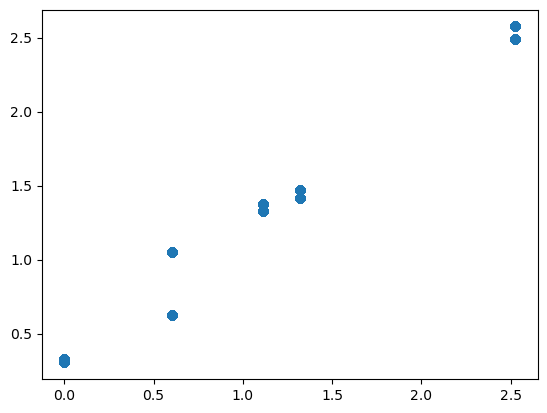

In [16]:
# Filter out rows where Age is not 'predictme'
merged_df_plot = merged_df_predict[merged_df_predict.Age != 'predictme']

# Extract unique pairs of (Age, Predicted)
x, y = zip(*list(set([(i, j) for i, j in zip(merged_df_plot.Age, merged_df_plot.Predicted)])))

# Convert the values of Age and Predicted back from logarithmic scale
x = [10**float(i) for i in x]
y = [10**float(i) for i in y]

# Calculate Mean Squared Error and R-squared
mse = mean_squared_error(x, y)
r2 = r2_score(x, y)

# Print evaluation metrics
print(f'Mean Squared Error (median): {mse}')
print(f'R-squared (median): {r2}')

# Plot predicted ages against actual ages
plt.scatter(merged_df_plot['Age'], merged_df_plot['Predicted'])
plt.savefig('test_cases.pdf')  # Save the plot as a PDF file

In [17]:
# Filter rows where Age is 'predictme'
test_cases = merged_df_predict[merged_df_predict.Age == 'predictme']

# Create a dictionary mapping batch names to predicted ages
test_cases_dict = {i: 10**j for i, j in zip(test_cases.Batch, test_cases.Predicted)}

# Print the dictionary
test_cases_dict

{'2023-06-16_Puck_230117_11': 41.5152403767907,
 '2023-06-16_Puck_230117_12': 28.440312016311328,
 '2023-09-08_Puck_230525_11': 44.76566664595877,
 '2023-09-08_Puck_230525_13': 40.859725601100706,
 '2023-06-13_Puck_230130_22': 49.60153240652729,
 '2023-06-13_Puck_230130_23': 52.15819583786661,
 '2023-09-08_Puck_230707_19': 24.111672067227733,
 '2023-09-08_Puck_230707_20': 30.49705355538796,
 '2023-09-08_Puck_230609_06': 45.79051022452958,
 '2023-09-14_Puck_230614_10': 70.36881146497566}

In [18]:
# Model on tests

# Step 6: Model Evaluation
y_pred = model.predict(X_train_combined)

metadata_train = adata_train.obs[['Batch','Age','Cell_type']]
metadata_train['Age'] = np.log10([i for i in metadata_train['Age']])

# Group predictions by 'Batch' and calculate the median prediction for each group
train_by_batch = pd.DataFrame({'Actual': y_train, 'Predicted': y_pred, 
                               'Batch': metadata_train['Batch'],
                              'Cell_type':metadata_train['Cell_type']})
median_predictions_by_batch = train_by_batch.groupby('Batch')['Predicted'].median().reset_index()

# Merge median predictions back into the original dataset
merged_df_train = pd.merge(metadata_train, median_predictions_by_batch, on='Batch', how='left')

# Evaluate the median predictions
mse = mean_squared_error(merged_df_train['Age'], merged_df_train['Predicted'])
r2 = r2_score(merged_df_train['Age'], merged_df_train['Predicted'])

print(f'Mean Squared Error (median): {mse}')
print(f'R-squared (median): {r2}')

/tmp/ipykernel_26037/2756299297.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_train['Age'] = np.log10([i for i in metadata_train['Age']])


Mean Squared Error (median): 0.05575906297477595
R-squared (median): 0.8732073903018751


410.3959654792534


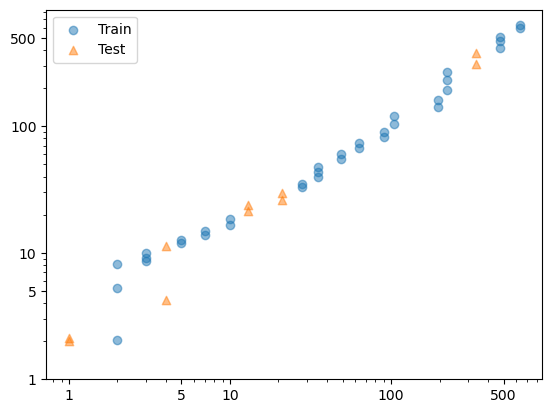

In [20]:

# Filter out non-numeric batch values from merged_df_train
merged_df = merged_df_train[merged_df_train['Batch'].apply(lambda x: isinstance(x, (int, float)))]

# Extract unique pairs of (Age, Predicted) for training set
fig, ax = plt.subplots()
x, y = zip(*list(set([(i, j) for i, j in zip(merged_df.Age, merged_df.Predicted)])))
x = [10**i for i in x]  # Convert Age values back from logarithmic scale
y = [10**i for i in y]  # Convert Predicted values back from logarithmic scale
plt.scatter(x, y, label='Train', alpha=0.5)  # Plot training set data

# Extract unique pairs of (Age, Predicted) for test set
x2, y2 = zip(*list(set([(i, j) for i, j in zip(merged_df_plot.Age, merged_df_plot.Predicted)])))
x2 = [10**i for i in x2]  # Convert Age values back from logarithmic scale
y2 = [10**i for i in y2]  # Convert Predicted values back from logarithmic scale
plt.scatter(x2, y2, marker='^', label='Test', alpha=0.5)  # Plot test set data

# Calculate mean squared error for the training set
mse = mean_squared_error(x, y)
print(mse)

# Set x-axis to logarithmic scale
ax.set_xscale('log', base=10)
ax.set_xticks([1, 5, 10, 100, 500])
ax.get_xaxis().set_major_formatter(ScalarFormatter())

# Set y-axis to logarithmic scale
ax.set_yscale('log', base=10)
ax.set_yticks([1, 5, 10, 100, 500])
ax.get_yaxis().set_major_formatter(ScalarFormatter())

# Save the plot as a PDF file
plt.savefig('model_performance.pdf')

# Add legend to the plot
plt.legend()

In [23]:
from sklearn.metrics import mean_absolute_percentage_error

# Calculate the mean absolute percentage error
mape_average = mean_absolute_percentage_error(x, y)

# Print the result
print(f'Mean Absolute Percentage Error (MAPE): {mape_average}')


0.5891442577544952

In [26]:
# Create a dictionary mapping batch names to predicted ages for training data
test = {i: 10**j for i, j in zip(merged_df.Batch, merged_df.Predicted)}

# Print the dictionary
test

{4: 2.040085296115165,
 5: 5.2763936208542,
 6: 8.187583165176013,
 7: 8.566604414503974,
 8: 9.05973484104707,
 9: 10.00826686476721,
 12: 11.9668124671175,
 13: 12.686389316456918,
 14: 13.821026873943724,
 15: 14.905952924907652,
 16: 16.562726934561987,
 17: 18.47717831482568,
 22: 32.85929859793016,
 23: 35.1028145138411,
 24: 39.32595474338329,
 25: 43.40847690352518,
 26: 47.565355880994666,
 27: 54.865879309367955,
 28: 60.490679890433654,
 29: 67.18949852784736,
 30: 74.32806279254596,
 31: 82.52876518455541,
 32: 89.80611258529241,
 33: 103.52528074730809,
 34: 120.11434651602309,
 35: 140.93958611252478,
 36: 160.61174977844848,
 37: 191.873444120324,
 38: 232.18170214839336,
 39: 269.8275021820471,
 42: 417.99932817615627,
 43: 468.9462295800634,
 44: 503.1691487170729,
 45: 594.2838329011701,
 46: 625.7449458452567}

In [28]:
# Create a dictionary mapping batch names to predicted ages for training data
test = {i: 10**j for i, j in zip(merged_df_train.Batch, merged_df_train.Predicted)}

# Print the dictionary
test

{4: 2.040085296115165,
 5: 5.2763936208542,
 6: 8.187583165176013,
 7: 8.566604414503974,
 8: 9.05973484104707,
 9: 10.00826686476721,
 12: 11.9668124671175,
 13: 12.686389316456918,
 14: 13.821026873943724,
 15: 14.905952924907652,
 16: 16.562726934561987,
 17: 18.47717831482568,
 22: 32.85929859793016,
 23: 35.1028145138411,
 24: 39.32595474338329,
 25: 43.40847690352518,
 26: 47.565355880994666,
 27: 54.865879309367955,
 28: 60.490679890433654,
 29: 67.18949852784736,
 30: 74.32806279254596,
 31: 82.52876518455541,
 32: 89.80611258529241,
 33: 103.52528074730809,
 34: 120.11434651602309,
 35: 140.93958611252478,
 36: 160.61174977844848,
 37: 191.873444120324,
 38: 232.18170214839336,
 39: 269.8275021820471,
 42: 417.99932817615627,
 43: 468.9462295800634,
 44: 503.1691487170729,
 45: 594.2838329011701,
 46: 625.7449458452567,
 '2023-06-16_Puck_230117_08': 31.054364492048418,
 '2023-06-16_Puck_230117_10': 35.46397858729666,
 '2023-09-08_Puck_230525_18': 37.519224544754955,
 '2023-09-

/tmp/ipykernel_26037/2518658094.py:30: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(x='Condition', y='Values', data=data, bw=0.2)


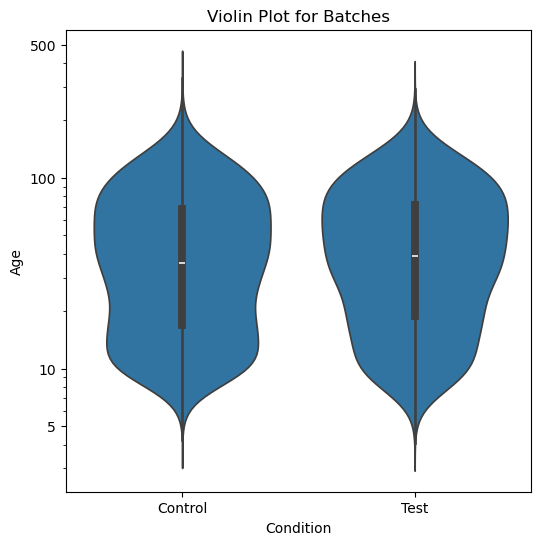

T-Statistic: -14.1302, p-value: 0.0000


In [51]:
# Define the lists of puck names for test and control groups
pntest = ['2023-06-16_Puck_230117_11', '2023-06-16_Puck_230117_12',
          '2023-09-08_Puck_230525_11', '2023-09-08_Puck_230525_13']  # Test
pncont = ['2023-06-16_Puck_230117_08', '2023-06-16_Puck_230117_10',
          '2023-09-08_Puck_230525_18', '2023-09-08_Puck_230525_19']  # Control

# Assuming val1 and val2 are NumPy arrays
# Get the predicted values for each batch
trainfilt = train_by_batch[train_by_batch.Batch.isin(pncont)]
testfilt = predictions_by_batch[predictions_by_batch.Batch.isin(pntest)]

val1 = 10 ** trainfilt.Predicted
val2 = 10 ** testfilt.Predicted

# Create a combined dataset with condition labels for violin plot
data = pd.DataFrame({
    'Values': np.concatenate([val1, val2]),
    'Condition': ['Control'] * len(val1) + ['Test'] * len(val2)
})


fig, ax = plt.subplots(figsize=(6, 6))

# Set y-axis to logarithmic scale
ax.set_yscale('log', base=10)
ax.set_yticks([1, 5, 10, 100, 500])
ax.get_yaxis().set_major_formatter(ScalarFormatter())

# Create a violin plot
sns.violinplot(x='Condition', y='Values', data=data, bw=0.2)

# Set labels and title
plt.xlabel('Condition')
plt.ylabel('Age')
plt.title('Violin Plot for Batches')

# Show the plot
plt.show()

# Perform independent two-sample t-test
t_statistic, t_p_value = scipy.stats.ttest_ind(val1, val2)
print(f"T-Statistic: {t_statistic:.4f}, p-value: {t_p_value:.4f}")


In [52]:
ct_all = set(train_by_batch.Cell_type)
test =  train_by_batch[train_by_batch.Cell_type.isin([ct])]

In [ ]:
# Define puck names for test and control groups
pntest = ['2023-06-16_Puck_230117_11', '2023-06-16_Puck_230117_12',
          '2023-09-08_Puck_230525_11', '2023-09-08_Puck_230525_13']  # Test
pncont = ['2023-06-16_Puck_230117_08', '2023-06-16_Puck_230117_10',
          '2023-09-08_Puck_230525_18', '2023-09-08_Puck_230525_19']  # Control
pncontregen = ['2023-09-08_Puck_230612_05', '2023-09-08_Puck_230612_22']
pntestregen = ['2023-09-08_Puck_230609_06', '2023-09-14_Puck_230614_10']

pval_corr_recorder = []

# Loop through each cell type
for ct in ct_all:
    # Filter train and test data by cell type and puck names
    trainfilt = train_by_batch[train_by_batch.Cell_type.isin([ct])]
    testfilt = predictions_by_batch[predictions_by_batch.Cell_type.isin([ct])]

    trainfilt = trainfilt[trainfilt.Batch.isin(pncont)]
    testfilt = testfilt[testfilt.Batch.isin(pntest)]

    # Calculate predicted values
    val1 = 10 ** trainfilt.Predicted
    val2 = 10 ** testfilt.Predicted

    # Perform t-test
    stat, sig = scipy.stats.ttest_ind(val1, val2)
    pval_corr_recorder.append(sig)

# Perform multiple testing correction
_, corr_dict = statsmodels.stats.multitest.fdrcorrection(pval_corr_recorder)
corr_dict = {i: j for i, j in zip(pval_corr_recorder, corr_dict)}

# Create subplots for violin plots
fig, axs = plt.subplots(5, 6, figsize=(5 * 6, 6 * 6))

# Loop through each cell type and plot violin plots
for ct, ax in zip(ct_all, axs.ravel()):
    # Filter train and test data by cell type and puck names
    trainfilt = train_by_batch[train_by_batch.Cell_type.isin([ct])]
    testfilt = predictions_by_batch[predictions_by_batch.Cell_type.isin([ct])]

    trainfilt = trainfilt[trainfilt.Batch.isin(pncont)]
    testfilt = testfilt[testfilt.Batch.isin(pntest)]

    # Calculate predicted values
    val1 = 10 ** trainfilt.Predicted
    val2 = 10 ** testfilt.Predicted

    # Perform t-test
    stat, sig = scipy.stats.ttest_ind(val1, val2)
    pcorr = corr_dict[sig]

    # Skip if p-value is not significant
    if pcorr >= 0.05:
        continue
    else:
        print(ct, pcorr)

    # Create a combined dataset with condition labels
    data = pd.DataFrame({
        'Values': np.concatenate([val1, val2]),
        'Condition': ['Control'] * len(val1) + ['Test'] * len(val2)
    })

    # Set y-axis to logarithmic scale
    ax.set_yscale('log', base=10)
    ax.set_yticks([1, 5, 10, 100, 500])
    ax.get_yaxis().set_major_formatter(ScalarFormatter())

    # Create a violin plot
    sns.violinplot(x='Condition', y='Values', data=data, bw=0.2, ax=ax)

    # Set title
    ax.set_title(f'Violin Plot for Batches, {ct}, {round(stat, 2)}, {round(pcorr, 2)}')

# Save and show the plot
plt.savefig('depl_model_age_cell_types.pdf')
plt.show()

TEC_early 0.005596246508678409


/tmp/ipykernel_26037/2121807902.py:70: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(x='Condition', y='Values', data=data, bw=0.2, ax=ax)


Ery 0.024396635108719818


/tmp/ipykernel_26037/2121807902.py:70: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(x='Condition', y='Values', data=data, bw=0.2, ax=ax)


cTEC 3.607502642332614e-11


/tmp/ipykernel_26037/2121807902.py:70: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(x='Condition', y='Values', data=data, bw=0.2, ax=ax)


CD8+T 6.894218303721746e-10


/tmp/ipykernel_26037/2121807902.py:70: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(x='Condition', y='Values', data=data, bw=0.2, ax=ax)


DC2 0.037057305330134724


/tmp/ipykernel_26037/2121807902.py:70: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(x='Condition', y='Values', data=data, bw=0.2, ax=ax)


DN(P) 0.038140148728764464


/tmp/ipykernel_26037/2121807902.py:70: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(x='Condition', y='Values', data=data, bw=0.2, ax=ax)


CD4+T 4.872209228351176e-28


/tmp/ipykernel_26037/2121807902.py:70: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(x='Condition', y='Values', data=data, bw=0.2, ax=ax)
/tmp/ipykernel_26037/2121807902.py:70: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(x='Condition', y='Values', data=data, bw=0.2, ax=ax)


Fb 0.03573732133801542
DP(P) 9.790729714041136e-19


/tmp/ipykernel_26037/2121807902.py:70: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(x='Condition', y='Values', data=data, bw=0.2, ax=ax)


mTEC 8.204152449820746e-05


/tmp/ipykernel_26037/2121807902.py:70: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(x='Condition', y='Values', data=data, bw=0.2, ax=ax)


Endo 3.3350126868308716e-16


/tmp/ipykernel_26037/2121807902.py:70: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(x='Condition', y='Values', data=data, bw=0.2, ax=ax)


DP(Q) 4.1077353212050136e-13


/tmp/ipykernel_26037/2121807902.py:70: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(x='Condition', y='Values', data=data, bw=0.2, ax=ax)


VSMC 4.954135360379737e-05
